In [ ]:
!nvidia-smi

Fri Jun 30 06:23:52 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    47W / 400W |      0MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from tokenization_roberta_spm import FairSeqRobertaSentencePieceTokenizer
from transformers import XLMRobertaForSequenceClassification
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
import os
from tqdm.auto import tqdm
from torch.utils.data import Dataset, DataLoader, TensorDataset, RandomSampler, SequentialSampler

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = XLMRobertaForSequenceClassification.from_pretrained("axiomlabs/KR-cryptoroberta-base", num_labels=3)
model.eval()
model.to(device)
print()

tokenizer = FairSeqRobertaSentencePieceTokenizer.from_pretrained("/content/drive/MyDrive/fairseq-roberta-all-model 2")


The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'RobertaTokenizer'. 
The class this function is called from is 'FairSeqRobertaSentencePieceTokenizer'.



[PASS] spm_id: madeupword0000 | fairseq_id: 51998
[PASS] spm_id: madeupword0001 | fairseq_id: 51999


In [ ]:
# from 2019-03-25 16:07:00 to 2023-06-28 15:34:00
news_df = pd.read_csv("/content/drive/MyDrive/coinness_full.csv")

news_df

,titles,contents,datetimes
0,"TUSD/USDT 페어, 오늘 최대 80센트까지 디페깅 심화",코인데스크가 트레이딩뷰 데이터를 인용해 바이낸스US 기준 TUSD/USDT 페어가 ...,2023-06-28 15:34:00
1,"BFC, 블록체인 게임 플랫폼 젬허브와 파트너십",바이프로스트(BFC)가 공식 미디엄을 통해 블록체인 게임 플랫폼 젬허브(GemHUB...,2023-06-28 15:31:00
2,"삭제 됐다던 탈중앙화 SNS 다무스, 앱스토어서 v1.5 출시",앱스토어에서 전날 삭제된 것으로 알려진 탈중앙화 소셜 네트워크 프로토콜 노스트(No...,2023-06-28 15:29:00
3,"외신 ""FTX 회계감사 맡았던 업체가 TUSD 감사도 수행""",코인데스크에 따르면 FTX 회계 감사를 맡았던 직원들이 설립한 암호화폐 기업 대상 ...,2023-06-28 15:15:00
4,"외신 ""EU 집행위, 스마트 컨트랙트 '킬스위치' 의무화법 초안 확정 초읽기""",코인데스크에 따르면 유럽연합(EU) 집행위원회가 암호화폐 업계의 반대에도 불구하고 ...,2023-06-28 15:10:00
...,...,...,...
109275,"이상민 의원, 블록체인 산업 진흥 법안 최초 발의...창업지원 등 내용 포함","25일 전자신문에 따르면, 더불어민주당 과학기술특별위원장 겸 정보통신특별위원장인 이...",2019-03-25 17:10:00
109276,"BTS·FSN, 업비트 BTC 마켓에 상장","국내 암호화폐 거래소 업비트가 비트쉐어(BTS, 시가 총액 43위), 퓨전(FSN,...",2019-03-25 17:09:00
109277,3월 25일 코인니스 호재 VS 악재 재료 분석 데일리 리포트,"코인니스는 최근 24시간 대표적인 재료를 분류, 관련 코인의 시장 데이터와 함께 투...",2019-03-25 16:49:00
109278,"외신 ""유니크레딧, 위트레이드 통해 블록체인 기반 현지 첫 광물 거래 진행""","암호화폐 전문 미디어 토큰포스트에 따르면, 유럽 9대 은행이자 이탈리아 대표 은행인...",2019-03-25 16:47:00


In [ ]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [ ]:
titles = news_df["titles"].values
contents = news_df["contents"].values
datetimes = news_df["datetimes"].values

input_ids, attn_masks = [], []
for i in tqdm(range(len(titles))):
  t1 = str(titles[i])
  t2 = str(contents[i])
  encoded_inputs = tokenizer(str(t1), str(t2), max_length=512, padding="max_length", truncation=True)
  input_ids.append(encoded_inputs["input_ids"])
  attn_masks.append(encoded_inputs["attention_mask"])

input_ids = torch.tensor(input_ids, dtype=int)
attn_masks = torch.tensor(attn_masks, dtype=int)

print(input_ids.shape, attn_masks.shape)

  0%|          | 0/109280 [00:00<?, ?it/s]

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


torch.Size([109280, 512]) torch.Size([109280, 512])


In [ ]:
test_data = TensorDataset(input_ids, attn_masks)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=32)

sentiment_scores = []

for step, batch in tqdm(enumerate(test_dataloader), desc="calculating sentiment scores", total=len(test_dataloader)):
  batch = (t.to(device) for t in batch)
  b_input_ids, b_attn_masks = batch
  with torch.no_grad():
    output = model(b_input_ids, b_attn_masks).logits
    output = nn.Softmax(dim=1)(output[:, :2])
    output = output.detach().cpu().numpy()
    sentiment_scores.extend(output)

calculating sentiment scores:   0%|          | 0/3415 [00:00<?, ?it/s]

In [ ]:
sentiment_df = pd.DataFrame(sentiment_scores, columns=["positive_sentiment", "negative_sentiment"])

sentiment_df

,positive_sentiment,negative_sentiment
0,0.429200,0.570800
1,0.547820,0.452180
2,0.353701,0.646299
3,0.520685,0.479315
4,0.616102,0.383898
...,...,...
109275,0.849366,0.150634
109276,0.716214,0.283786
109277,0.793847,0.206153
109278,0.790685,0.209315


In [ ]:
sentiment_df.to_csv("/content/drive/MyDrive/sentiment_df", index=False)

print("done saving!")

done saving!


In [ ]:
import ccxt
import json

with open("/content/drive/MyDrive/upbit_data/BTC_USDT-4h-20.json", "r") as f:
    chart_data = json.load(f)
    chart_df = pd.DataFrame(chart_data)
    chart_df = chart_df.rename(columns={0:"timestamp", 1:"open", 2:"high", 3:"low", 4:"close", 5:"volume"})

# decipher time information
dates = chart_df["timestamp"].values
timestamp = []
exchange = ccxt.binance()
for i in range(len(dates)):
  date_string = exchange.iso8601(int(dates[i]))
  date_string = date_string[:10] + " " + date_string[11:-5]
  timestamp.append(date_string)
chart_df["datetime"] = timestamp
chart_df.drop(columns={"timestamp"}, inplace=True)
chart_df.set_index(pd.DatetimeIndex(chart_df["datetime"]), inplace=True)

chart_df

,open,high,low,close,volume,datetime
datetime,,,,,,
2017-08-17 04:00:00,4261.48,4349.99,4261.32,4349.99,82.088865,2017-08-17 04:00:00
2017-08-17 08:00:00,4333.32,4485.39,4333.32,4427.30,63.619882,2017-08-17 08:00:00
2017-08-17 12:00:00,4436.06,4485.39,4333.42,4352.34,174.562001,2017-08-17 12:00:00
2017-08-17 16:00:00,4352.33,4354.84,4200.74,4325.23,225.109716,2017-08-17 16:00:00
2017-08-17 20:00:00,4307.56,4369.69,4258.56,4285.08,249.769913,2017-08-17 20:00:00
...,...,...,...,...,...,...
2023-06-28 12:00:00,30310.73,30490.86,30009.00,30411.06,10958.226270,2023-06-28 12:00:00
2023-06-28 16:00:00,30411.07,30466.36,29858.80,30100.00,9490.074970,2023-06-28 16:00:00
2023-06-28 20:00:00,30099.99,30218.55,29948.82,30077.41,3952.897370,2023-06-28 20:00:00


In [ ]:
from datetime import datetime

for i in range(len(timestamp)):
  dt_object = datetime.strptime(timestamp[i], "%Y-%m-%d %H:%M:%S")
  if dt_object >= datetime(2019, 3, 25, 16, 0, 0):
    print(i)
    break

3501


In [ ]:
# match news and chart timeframes
chart_df = chart_df.iloc[3501:]
chart_df

,open,high,low,close,volume,datetime
datetime,,,,,,
2019-03-25 16:00:00,3962.92,3982.24,3888.71,3922.22,10701.099642,2019-03-25 16:00:00
2019-03-25 20:00:00,3922.22,3946.82,3891.14,3936.12,4833.956259,2019-03-25 20:00:00
2019-03-26 00:00:00,3935.47,3958.98,3931.00,3937.26,2984.940558,2019-03-26 00:00:00
2019-03-26 04:00:00,3936.14,3944.63,3909.11,3925.98,3922.436901,2019-03-26 04:00:00
2019-03-26 08:00:00,3925.98,3940.62,3913.00,3918.06,6771.990081,2019-03-26 08:00:00
...,...,...,...,...,...,...
2023-06-28 12:00:00,30310.73,30490.86,30009.00,30411.06,10958.226270,2023-06-28 12:00:00
2023-06-28 16:00:00,30411.07,30466.36,29858.80,30100.00,9490.074970,2023-06-28 16:00:00
2023-06-28 20:00:00,30099.99,30218.55,29948.82,30077.41,3952.897370,2023-06-28 20:00:00


In [ ]:
chart_df.to_csv("/content/drive/MyDrive/20230629_chart_df.csv", index=False)

In [ ]:
# add labels
def add_label(threshold):
  close = chart_df["close"].values
  high = chart_df["high"].values
  low = chart_df["low"].values
  targets = []
  for i in range(len(close)-1):
    high_vol = (high[i+1] - close[i]) / close[i] * 100
    low_vol = (low[i+1] - close[i]) / close[i] * 100
    if max(high_vol, np.abs(low_vol)) < threshold:
      targets.append(2)
    else:
      if high_vol >= np.abs(low_vol):
        targets.append(0)
      elif high_vol < np.abs(low_vol):
        targets.append(1)
  targets.append(None)
  return targets

targets = add_label(0.75)

chart_df["targets"] = targets
chart_df.dropna(inplace=True)

chart_df.shape

<ipython-input-66-9c2676941c17>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chart_df["targets"] = targets
<ipython-input-66-9c2676941c17>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chart_df.dropna(inplace=True)


(9335, 7)

<Axes: xlabel='targets', ylabel='count'>

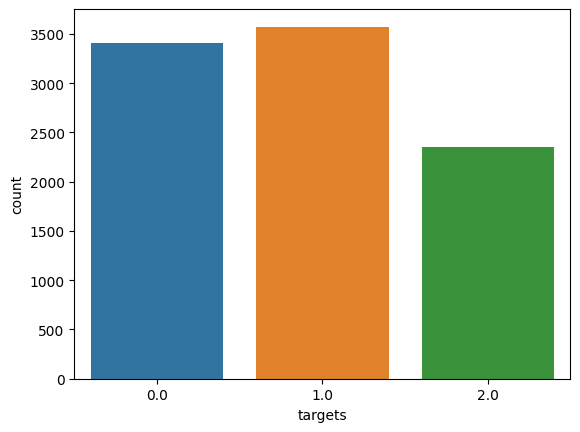

In [ ]:
import seaborn as sns

sns.countplot(x='targets', data=chart_df)

In [ ]:
# group sentiment scores
from datetime import timedelta

chart_dt = chart_df["datetime"].values

positive_scores = sentiment_df["positive_sentiment"].values[::-1]
negative_scores = sentiment_df["negative_sentiment"].values[::-1]
news_dt = news_df["datetimes"].values[::-1]


cum_pos, cum_neg = [], []

for dt in tqdm(chart_dt, desc="calculating 4 hour cumulative sentiment scores"):
  end_chart_dt = datetime.strptime(dt, "%Y-%m-%d %H:%M:%S")
  start_chart_dt = end_chart_dt - timedelta(hours=4)
  positive_sum, negative_sum = 0, 0
  for i in range(len(news_dt)):
    news_dt_obj = datetime.strptime(news_dt[i], "%Y-%m-%d %H:%M:%S")
    if news_dt_obj >= start_chart_dt and news_dt_obj <= end_chart_dt:
      positive_sum += positive_scores[i]
      negative_sum += negative_scores[i]
    if news_dt_obj > end_chart_dt:
      break
  cum_pos.append(positive_sum)
  cum_neg.append(negative_sum)


calculating 4 hour cumulative sentiment scores:   0%|          | 0/9335 [00:00<?, ?it/s]

In [ ]:
chart_df["news_positive_scores"] = cum_pos
chart_df["news_negative_scores"] = cum_neg
chart_df

<ipython-input-83-e2c02bcc0989>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chart_df["news_positive_scores"] = cum_pos
<ipython-input-83-e2c02bcc0989>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chart_df["news_negative_scores"] = cum_neg


,open,high,low,close,volume,datetime,targets,news_positive_scores,news_negative_scores
datetime,,,,,,,,,
2019-03-25 16:00:00,3962.92,3982.24,3888.71,3922.22,10701.099642,2019-03-25 16:00:00,1.0,0.000000,0.000000
2019-03-25 20:00:00,3922.22,3946.82,3891.14,3936.12,4833.956259,2019-03-25 20:00:00,2.0,9.476807,5.523193
2019-03-26 00:00:00,3935.47,3958.98,3931.00,3937.26,2984.940558,2019-03-26 00:00:00,2.0,5.260066,2.739934
2019-03-26 04:00:00,3936.14,3944.63,3909.11,3925.98,3922.436901,2019-03-26 04:00:00,2.0,7.899933,2.100068
2019-03-26 08:00:00,3925.98,3940.62,3913.00,3918.06,6771.990081,2019-03-26 08:00:00,2.0,5.258174,2.741826
...,...,...,...,...,...,...,...,...,...
2023-06-28 08:00:00,30186.14,30388.00,30150.98,30310.73,4469.601450,2023-06-28 08:00:00,1.0,5.845744,3.154256
2023-06-28 12:00:00,30310.73,30490.86,30009.00,30411.06,10958.226270,2023-06-28 12:00:00,1.0,12.035022,5.964978
2023-06-28 16:00:00,30411.07,30466.36,29858.80,30100.00,9490.074970,2023-06-28 16:00:00,2.0,9.597610,12.402390


In [ ]:
chart_df.to_csv("/content/drive/MyDrive/chart_with_sentiment_scores.csv",index=False)

In [ ]:
# add technical indicators
import pandas_ta as ta
hours, days, months = [], [], []
for dt in tqdm(chart_df["datetime"]):
  dtobj = pd.to_datetime(dt)
  hours.append(dtobj.hour)
  days.append(dtobj.day)
  months.append(dtobj.month)

chart_df["hours"] = hours
chart_df["days"] = days
chart_df["months"] = months

chart_df["ebsw"] = chart_df.ta.ebsw(lookahead=False)
chart_df["cmf"] = chart_df.ta.cmf(lookahead=False)
chart_df["bop"] = chart_df.ta.bop(lookahead=False)
chart_df["rsi/100"] = chart_df.ta.rsi(lookahead=False) / 100.0
chart_df["hwma"] = chart_df.ta.hwma(lookahead=False)
chart_df["linreg"] = chart_df.ta.linreg(lookahead=False)
chart_df["hwma/close"] = chart_df["hwma"] / chart_df["close"]
chart_df["linreg/close"] = chart_df["linreg"] / chart_df["close"]
chart_df["high/low"] = chart_df["high"] / chart_df["low"]
chart_df["high/open"] = chart_df["high"] / chart_df["open"]
chart_df["low/open"] = chart_df["low"] / chart_df["open"]
chart_df["close/open"] = chart_df["close"] / chart_df["open"]
chart_df["high/close"] = chart_df["high"] / chart_df["close"]
chart_df["low/close"]  = chart_df["low"] / chart_df["close"]

for l in range(1, 6):
  for col in ["open", "high", "low", "close", "volume"]:
    val = chart_df[col].values
    val_ret = [None for _ in range(l)]
    for i in range(l, len(val)):
      if val[i-l] == 0:
        ret = 1
      else:
        ret = val[i] / val[i-l]
      val_ret.append(ret)
    chart_df[f"{col}_change_{l}"] = val_ret

chart_df = chart_df.drop(columns={"datetime", "open", "high", "low", "close", "volume", "linreg", "hwma"})


  0%|          | 0/9335 [00:00<?, ?it/s]

<ipython-input-88-060bac6f77e9>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chart_df["hours"] = hours
<ipython-input-88-060bac6f77e9>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chart_df["days"] = days
<ipython-input-88-060bac6f77e9>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retur

KeyError: ignored

In [ ]:
chart_df.dropna(inplace=True)

<ipython-input-90-468052f14293>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chart_df.dropna(inplace=True)


In [ ]:
chart_df.drop(columns={"datetime"}, inplace=True)

<ipython-input-94-7cefc8a35ec1>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chart_df.drop(columns={"datetime"}, inplace=True)


In [ ]:
train_columns = []

for col in chart_df.columns:
  if col != "targets":
    train_columns.append(col)

X = chart_df[train_columns]
Y = chart_df["targets"]

In [ ]:
import optuna
import xgboost as xgb
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import accuracy_score

def objective(trial):
  params = {
      "objective": "multi:softmax",
      "num_class": 3,
      "eval_metric": "merror",
      "subsample": trial.suggest_float("subsample", 0.5, 1.0),
      "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
      "max_depth": trial.suggest_int("max_depth", 3, 10),
      "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.1),
      "min_child_weight": trial.suggest_float("min_child_weight", 1, 10),
      "gamma": trial.suggest_float("gamma", 0, 10),
      "n_estimators": trial.suggest_int("n_estimators", 50, 5000),
      "tree_method": "gpu_hist"
  }
  # perform walk-forward cross-validation
  tscv = TimeSeriesSplit(n_splits=5)
  accuracies = []
  for train_index, val_index in tscv.split(X):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    Y_train, Y_val = Y.iloc[train_index], Y.iloc[val_index]
    model = xgb.XGBClassifier(**params)
    model.fit(X_train, Y_train, eval_set=[(X_val, Y_val)], verbose=False)
    Y_pred = model.predict(X_val)
    accuracy = accuracy_score(Y_val, Y_pred)
    accuracies.append(accuracy)
  return sum(accuracies) / len(accuracies)

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)
best_params = study.best_params
print(f"Best Parameters: {best_params}")

[I 2023-06-30 10:32:49,339] A new study created in memory with name: no-name-ae8bfda1-3497-42a9-b316-4aa48468c8df
[I 2023-06-30 10:33:09,808] Trial 0 finished with value: 0.45345384118786314 and parameters: {'subsample': 0.7114849143389773, 'colsample_bytree': 0.9473602755894266, 'max_depth': 10, 'learning_rate': 0.049799882700234485, 'min_child_weight': 3.4032134186458958, 'gamma': 6.528494475152393, 'n_estimators': 1559}. Best is trial 0 with value: 0.45345384118786314.
[I 2023-06-30 10:33:54,962] Trial 1 finished with value: 0.43950936087798576 and parameters: {'subsample': 0.8766209680938235, 'colsample_bytree': 0.6741623449997658, 'max_depth': 10, 'learning_rate': 0.046034268642013175, 'min_child_weight': 8.480442628731538, 'gamma': 8.284235300214156, 'n_estimators': 3544}. Best is trial 0 with value: 0.45345384118786314.
[I 2023-06-30 10:34:01,610] Trial 2 finished with value: 0.43873466752743706 and parameters: {'subsample': 0.6447052758435925, 'colsample_bytree': 0.968263064999

Best Parameters: {'subsample': 0.7794564925617046, 'colsample_bytree': 0.9953018636025351, 'max_depth': 9, 'learning_rate': 0.013138686044784876, 'min_child_weight': 9.040062755238312, 'gamma': 2.1660919252569797, 'n_estimators': 1847}
